Partie 1: Classification d'images avec CNN sur CIFAR-10
1. Chargement et prétraitement des données

In [1]:
!pip install torch torchvision matplotlib numpy scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

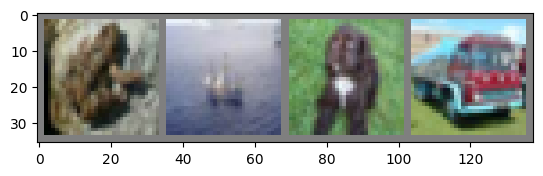

frog  ship  dog   truck


In [3]:
# Définition des transformations
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transformation avec augmentation de données
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement des ensembles d'entraînement et de test
trainset_basic = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_basic)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_basic)

trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_augmented)

# Création des DataLoaders
batch_size = 32

trainloader_basic = DataLoader(trainset_basic, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader_augmented = DataLoader(trainset_augmented, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes du CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualisation de quelques images
def imshow(img):
    img = img / 2 + 0.5  # dénormalisation
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Affichage d'images aléatoires
dataiter = iter(trainloader_basic)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

2. Définition de l'architecture CNN

In [4]:
class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        # Couche convolutionnelle 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # Couche convolutionnelle 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Couche convolutionnelle 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # Couche de pooling
        self.pool = nn.MaxPool2d(2, 2)
        # Couche fully connected 1
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        # Couche fully connected 2 (sortie)
        self.fc2 = nn.Linear(512, 10)
        # Dropout pour la régularisation
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))
        # Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))
        # Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        # FC -> ReLU -> Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # FC (sortie)
        x = self.fc2(x)
        return x

# Initialisation du modèle
model = CNN_CIFAR()
print(model)

CNN_CIFAR(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


3. Entraînement du modèle

In [5]:
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fonction d'entraînement
def train_model(trainloader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 500 == 499:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 500:.3f}')
                running_loss = 0.0
    print('Finished Training')

# Entraînement sans augmentation de données
print("Training without data augmentation...")
train_model(trainloader_basic, model, criterion, optimizer, num_epochs=10)

# Sauvegarde du modèle
torch.save(model.state_dict(), 'cifar_cnn_basic.pth')

# Réinitialisation du modèle pour l'entraînement avec augmentation
model_augmented = CNN_CIFAR()
optimizer_augmented = optim.Adam(model_augmented.parameters(), lr=0.001)

# Entraînement avec augmentation de données
print("\nTraining with data augmentation...")
train_model(trainloader_augmented, model_augmented, criterion, optimizer_augmented, num_epochs=10)

# Sauvegarde du modèle
torch.save(model_augmented.state_dict(), 'cifar_cnn_augmented.pth')

Training without data augmentation...
Epoch 1, Batch 500, Loss: 1.614
Epoch 1, Batch 1000, Loss: 1.254
Epoch 1, Batch 1500, Loss: 1.107
Epoch 2, Batch 500, Loss: 0.947
Epoch 2, Batch 1000, Loss: 0.909
Epoch 2, Batch 1500, Loss: 0.859
Epoch 3, Batch 500, Loss: 0.744
Epoch 3, Batch 1000, Loss: 0.728
Epoch 3, Batch 1500, Loss: 0.718
Epoch 4, Batch 500, Loss: 0.605
Epoch 4, Batch 1000, Loss: 0.618
Epoch 4, Batch 1500, Loss: 0.611
Epoch 5, Batch 500, Loss: 0.497
Epoch 5, Batch 1000, Loss: 0.506
Epoch 5, Batch 1500, Loss: 0.530
Epoch 6, Batch 500, Loss: 0.396
Epoch 6, Batch 1000, Loss: 0.448
Epoch 6, Batch 1500, Loss: 0.454
Epoch 7, Batch 500, Loss: 0.332
Epoch 7, Batch 1000, Loss: 0.363
Epoch 7, Batch 1500, Loss: 0.384
Epoch 8, Batch 500, Loss: 0.269
Epoch 8, Batch 1000, Loss: 0.300
Epoch 8, Batch 1500, Loss: 0.330
Epoch 9, Batch 500, Loss: 0.222
Epoch 9, Batch 1000, Loss: 0.260
Epoch 9, Batch 1500, Loss: 0.293
Epoch 10, Batch 500, Loss: 0.195
Epoch 10, Batch 1000, Loss: 0.233
Epoch 10, Bat

4. Évaluation des modèles

In [6]:
def evaluate_model(testloader, model):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# Chargement des modèles (au cas où on exécute cette cellule séparément)
model.load_state_dict(torch.load('cifar_cnn_basic.pth'))
model_augmented.load_state_dict(torch.load('cifar_cnn_augmented.pth'))

# Évaluation
print("Evaluation of model without data augmentation:")
accuracy_basic = evaluate_model(testloader, model)

print("\nEvaluation of model with data augmentation:")
accuracy_augmented = evaluate_model(testloader, model_augmented)

# Comparaison des performances
print(f"\nAccuracy improvement with data augmentation: {accuracy_augmented - accuracy_basic:.2f}%")

Evaluation of model without data augmentation:
Accuracy on test set: 76.01%

Evaluation of model with data augmentation:
Accuracy on test set: 78.47%

Accuracy improvement with data augmentation: 2.46%
